In [9]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

### Input Data and Dimensions

In [10]:
from sklearn.preprocessing import normalize

#Input data
dir = 'final_10to35_4/'
data = np.load(dir+'vibli_feature.npy')
data = normalize(data)
data = torch.from_numpy(data)

#Input data dimensions
n_samples = data.size()[0]
n_features = data.size()[1]
print(data.size())
#Latent dimensions
latent_dim = 2

torch.Size([867, 180])


In [11]:
#Model architecture and workflow

#Input high-dimensional data-->
#encoder to low-dimensional latent dimensions-->
#mean, std-->
#parametrization trick-->
#decoder to reconstructed output data

### Construct the Model

In [12]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, n_features, n_samples, latent_dim):
        super().__init__()
        #encoder
        self.img_2hid1 = nn.Linear(n_features, n_samples)
        self.img_2hid2 = nn.Linear(n_samples, n_samples)
        self.hid_2mu = nn.Linear(n_samples, latent_dim)
        self.hid_2sigma = nn.Linear(n_samples, latent_dim)
        
        #decoder
        self.z_2hid = nn.Linear(latent_dim,n_samples)
        self.hid_2img = nn.Linear(n_samples, n_features)
        
        self.relu = nn.ReLU()
        
    def encode(self, x):
        h1 = self.relu(self.img_2hid1(x))
        h2 = self.relu(self.img_2hid2(h1))
        mu, sigma = self.hid_2mu(h2), self.hid_2sigma(h2)
        
        return mu, sigma
    
    def decode(self, z):
        h = self.relu(self.z_2hid(z))
        return torch.sigmoid(self.hid_2img(h))
    
    def forward(self, x):
        mu, sigma = self.encode(x)
        epsilon = torch.randn_like(sigma)
        
        z_reparametrized = mu + sigma * epsilon
        x_reconstructed = self.decode(z_reparametrized)
        
        return x_reconstructed, mu, sigma

In [13]:
##A randn check of the model.
if __name__ == "__main__":
    x = data.float()
    vae = VariationalAutoEncoder(n_features, n_samples, latent_dim)
    x_reconstructed, mu, sigma = vae(x)
    print(x_reconstructed.shape)
    print(mu.shape)
    print(sigma.shape)
    print(x_reconstructed)

torch.Size([867, 180])
torch.Size([867, 2])
torch.Size([867, 2])
tensor([[0.4212, 0.4407, 0.4165,  ..., 0.5366, 0.3850, 0.4973],
        [0.4236, 0.4393, 0.4207,  ..., 0.5365, 0.3783, 0.5011],
        [0.4249, 0.4378, 0.4221,  ..., 0.5382, 0.3764, 0.5017],
        ...,
        [0.4248, 0.4378, 0.4219,  ..., 0.5384, 0.3770, 0.5013],
        [0.4237, 0.4389, 0.4206,  ..., 0.5373, 0.3788, 0.5006],
        [0.4270, 0.4366, 0.4246,  ..., 0.5387, 0.3713, 0.5036]],
       grad_fn=<SigmoidBackward0>)


### Train the Model

In [14]:
import torch
import torchvision.datasets as datasets #Standard datasets
from tqdm import tqdm
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

In [15]:
#Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 10
BATCH_SIZE = 100
LR_RATE = 1e-4 #Karpathy constant, too large
train_loader = DataLoader(dataset=x, batch_size=BATCH_SIZE, shuffle=True)
loss_fn = nn.BCELoss(reduction='sum') #MSE_loss, BCELoss y_i * (log())

In [16]:
def train(model):
    losses = []
    for epoch in range(NUM_EPOCHS):
        loop = tqdm(enumerate(train_loader)) #get progress bar
        for i, x in loop:
            #forward pass
            x = x.to(DEVICE).view(x.shape[0], n_features) #view without a copy, reshape
            x_reconstructed, mu, sigma = model(x)
            #Compute loss
            reconstruction_loss = loss_fn(x_reconstructed, x)
            kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
            #push towards standard Gaussion; reconstruction
        
            #Backprop
            loss = reconstruction_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
    return model, losses

In [17]:
loss_lat = []
step = 2
for latent_dim in range(2, 21, step):
    print('LATENT DIMENSIONS: '+str(latent_dim))
    model = VariationalAutoEncoder(n_features, n_samples, latent_dim).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
    model_train, losses = train(model)
    loss_lat.append(losses)

LATENT DIMENSIONS: 2


9it [00:00, 54.03it/s, loss=8.26e+3]
9it [00:00, 61.48it/s, loss=7.39e+3]
9it [00:00, 60.69it/s, loss=6.61e+3]
9it [00:00, 63.91it/s, loss=5.8e+3] 
9it [00:00, 61.03it/s, loss=4.93e+3]
9it [00:00, 63.26it/s, loss=4.07e+3]
9it [00:00, 59.83it/s, loss=2.96e+3]
9it [00:00, 65.92it/s, loss=2.6e+3] 
9it [00:00, 62.93it/s, loss=2.38e+3]
9it [00:00, 61.73it/s, loss=2.33e+3]


LATENT DIMENSIONS: 4


9it [00:00, 62.12it/s, loss=9.35e+3]
9it [00:00, 61.75it/s, loss=8.49e+3]
9it [00:00, 59.50it/s, loss=7.74e+3]
9it [00:00, 62.25it/s, loss=7.04e+3]
9it [00:00, 60.65it/s, loss=6.35e+3]
9it [00:00, 60.93it/s, loss=5.57e+3]
9it [00:00, 61.84it/s, loss=4.68e+3]
9it [00:00, 61.53it/s, loss=3.61e+3]
9it [00:00, 63.69it/s, loss=2.68e+3]
9it [00:00, 64.43it/s, loss=2.21e+3]


LATENT DIMENSIONS: 6


9it [00:00, 63.06it/s, loss=9.95e+3]
9it [00:00, 67.31it/s, loss=9.09e+3]
9it [00:00, 68.10it/s, loss=8.34e+3]
9it [00:00, 67.42it/s, loss=7.61e+3]
9it [00:00, 63.38it/s, loss=6.81e+3]
9it [00:00, 66.34it/s, loss=5.84e+3]
9it [00:00, 67.67it/s, loss=4.67e+3]
9it [00:00, 68.49it/s, loss=3.52e+3]
9it [00:00, 67.86it/s, loss=2.46e+3]
9it [00:00, 65.64it/s, loss=2.29e+3]


LATENT DIMENSIONS: 8


9it [00:00, 67.33it/s, loss=1.09e+4]
9it [00:00, 66.33it/s, loss=9.88e+3]
9it [00:00, 66.37it/s, loss=9.06e+3]
9it [00:00, 66.82it/s, loss=8.26e+3]
9it [00:00, 64.13it/s, loss=7.42e+3]
9it [00:00, 66.43it/s, loss=6.5e+3] 
9it [00:00, 66.19it/s, loss=5.36e+3]
9it [00:00, 67.59it/s, loss=4.08e+3]
9it [00:00, 66.22it/s, loss=2.95e+3]
9it [00:00, 67.70it/s, loss=2.35e+3]


LATENT DIMENSIONS: 10


9it [00:00, 64.14it/s, loss=1.18e+4]
9it [00:00, 63.08it/s, loss=1.08e+4]
9it [00:00, 62.47it/s, loss=9.97e+3]
9it [00:00, 60.62it/s, loss=9.16e+3]
9it [00:00, 65.12it/s, loss=8.36e+3]
9it [00:00, 66.28it/s, loss=7.47e+3]
9it [00:00, 64.75it/s, loss=6.54e+3]
9it [00:00, 64.81it/s, loss=5.35e+3]
9it [00:00, 62.06it/s, loss=4.26e+3]
9it [00:00, 64.86it/s, loss=3.12e+3]


LATENT DIMENSIONS: 12


9it [00:00, 64.73it/s, loss=1.23e+4]
9it [00:00, 65.01it/s, loss=1.11e+4]
9it [00:00, 57.98it/s, loss=1.01e+4]
9it [00:00, 60.90it/s, loss=9.18e+3]
9it [00:00, 61.39it/s, loss=8.17e+3]
9it [00:00, 61.54it/s, loss=6.94e+3]
9it [00:00, 63.50it/s, loss=5.31e+3]
9it [00:00, 66.42it/s, loss=3.83e+3]
9it [00:00, 67.27it/s, loss=2.72e+3]
9it [00:00, 65.34it/s, loss=2.42e+3]


LATENT DIMENSIONS: 14


9it [00:00, 64.03it/s, loss=1.27e+4]
9it [00:00, 61.93it/s, loss=1.13e+4]
9it [00:00, 59.45it/s, loss=1.02e+4]
9it [00:00, 61.24it/s, loss=9.11e+3]
9it [00:00, 63.75it/s, loss=7.79e+3]
9it [00:00, 63.25it/s, loss=6.23e+3]
9it [00:00, 62.33it/s, loss=4.56e+3]
9it [00:00, 64.74it/s, loss=3.23e+3]
9it [00:00, 64.11it/s, loss=2.78e+3]
9it [00:00, 61.12it/s, loss=2.44e+3]


LATENT DIMENSIONS: 16


9it [00:00, 64.28it/s, loss=1.4e+4] 
9it [00:00, 64.72it/s, loss=1.27e+4]
9it [00:00, 64.33it/s, loss=1.16e+4]
9it [00:00, 62.67it/s, loss=1.06e+4]
9it [00:00, 61.08it/s, loss=9.43e+3]
9it [00:00, 62.88it/s, loss=8.21e+3]
9it [00:00, 64.37it/s, loss=6.69e+3]
9it [00:00, 65.12it/s, loss=5.08e+3]
9it [00:00, 63.40it/s, loss=3.65e+3]
9it [00:00, 63.28it/s, loss=2.71e+3]


LATENT DIMENSIONS: 18


9it [00:00, 63.94it/s, loss=1.5e+4] 
9it [00:00, 67.15it/s, loss=1.36e+4]
9it [00:00, 64.80it/s, loss=1.25e+4]
9it [00:00, 62.28it/s, loss=1.14e+4]
9it [00:00, 63.87it/s, loss=1.02e+4]
9it [00:00, 65.31it/s, loss=8.92e+3]
9it [00:00, 45.68it/s, loss=7.57e+3]
9it [00:00, 66.98it/s, loss=5.88e+3]
9it [00:00, 70.51it/s, loss=4.12e+3]
9it [00:00, 69.84it/s, loss=3.17e+3]


LATENT DIMENSIONS: 20


9it [00:00, 67.31it/s, loss=1.49e+4]
9it [00:00, 67.05it/s, loss=1.32e+4]
9it [00:00, 66.36it/s, loss=1.18e+4]
9it [00:00, 61.60it/s, loss=1.03e+4]
9it [00:00, 64.26it/s, loss=8.83e+3]
9it [00:00, 66.90it/s, loss=7.05e+3]
9it [00:00, 64.25it/s, loss=5.01e+3]
9it [00:00, 65.02it/s, loss=3.54e+3]
9it [00:00, 68.15it/s, loss=2.8e+3] 
9it [00:00, 67.72it/s, loss=2.56e+3]


In [18]:
fs = 13

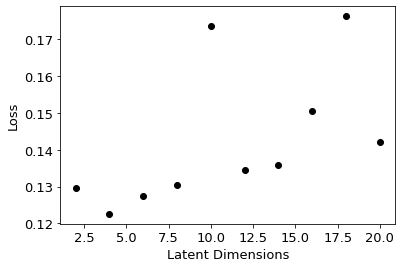

In [19]:
import matplotlib.pyplot as plt

for dim, losses in enumerate(loss_lat):
    plt.scatter(dim*step+2, losses[-1]/(BATCH_SIZE*n_features), color='k')
    plt.xlabel('Latent Dimensions', fontsize=fs)
    plt.ylabel('Loss', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

(array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
 [Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.7000000000000001, '0.7')])

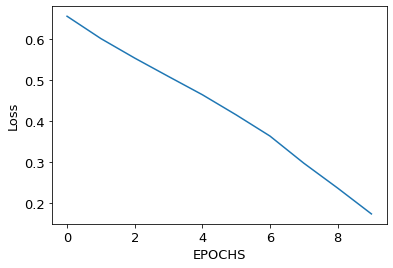

In [20]:
DIM = 10
actual_dim = int((DIM-2)/step)

plt.plot(np.array(loss_lat[actual_dim])/(BATCH_SIZE*n_features))
plt.xlabel('EPOCHS', fontsize=fs)
plt.ylabel('Loss', fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

In [21]:
#train for the desired number of dimensions

loss_lat = []
latent_dim = 10

model = VariationalAutoEncoder(n_features, n_samples, latent_dim).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR_RATE)
model_train, losses = train(model)
loss_lat.append(losses)

9it [00:00, 62.75it/s, loss=1.15e+4]
9it [00:00, 68.03it/s, loss=1.05e+4]
9it [00:00, 61.27it/s, loss=9.62e+3]
9it [00:00, 64.00it/s, loss=8.83e+3]
9it [00:00, 65.24it/s, loss=7.99e+3]
9it [00:00, 67.00it/s, loss=7.11e+3]
9it [00:00, 68.04it/s, loss=6058.25]
9it [00:00, 65.33it/s, loss=4.73e+3]
9it [00:00, 68.14it/s, loss=3.57e+3]
9it [00:00, 65.71it/s, loss=2.56e+3]


### Plot

In [22]:
#sigma
def plot_latent(model, data, NUM_EPOCHS=NUM_EPOCHS):
    for i, x in enumerate(data):
        z = model.encode(x.to(DEVICE))
        plt.plot(z[1]) #sigma
        if i > NUM_EPOCHS:
            break

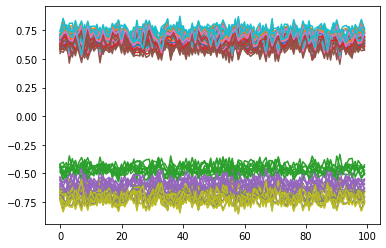

In [23]:
with torch.no_grad():
    plot_latent(model_train, train_loader)

In [24]:
#mu
def plot_latent(model, data, NUM_EPOCHS=NUM_EPOCHS):
    for i, x in enumerate(data):
        z = model.encode(x.to(DEVICE))
        plt.plot(z[0]) #mu
        if i > NUM_EPOCHS:
            break

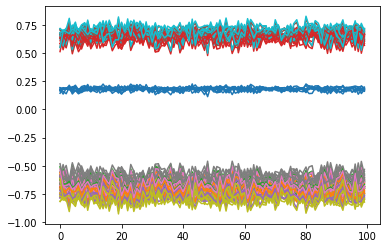

In [25]:
with torch.no_grad():
    plot_latent(model_train, train_loader)

In [26]:
#z gives the values for the features in the embedding

model.eval()

def plot_latent(model, data, NUM_EPOCHS=NUM_EPOCHS):
    mu, sigma = model.encode(x.to(DEVICE))
    epsilon = torch.randn_like(sigma)
    z = mu + sigma * epsilon
    plt.scatter(z[:,0], z[:,7])
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
            
    return z

torch.Size([867, 10])


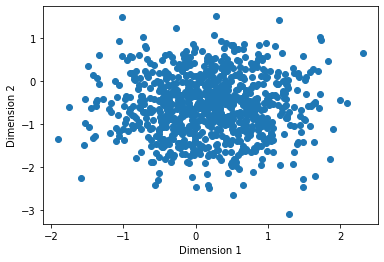

In [27]:
with torch.no_grad():
    z = plot_latent(model_train, train_loader)
    print(z.size())

### Save Data

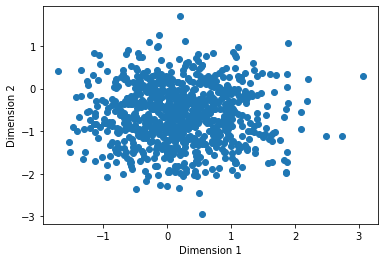

In [28]:
with torch.no_grad():
    z = plot_latent(model_train, train_loader)
    data_reduced = z.numpy()

In [29]:
np.save('lidos_f_vae', data_reduced)